In [248]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.parsing.porter import PorterStemmer
from gensim import corpora
import os
from xml.dom import minidom
import re
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

### Functions to read data

In [194]:
books_paths = os.path.join(os.getcwd(), 'datasets/sorted_data/books')
dvd_paths = os.path.join(os.getcwd(), 'datasets/sorted_data/dvd')
electronics_paths = os.path.join(os.getcwd(), 'datasets/sorted_data/electronics')
kitchen_paths = os.path.join(os.getcwd(), 'datasets/sorted_data/kitchen_&_housewares')
stop_words = stopwords.words('english')


def training_set_reader(path):
    documentos = []
    for filename in os.listdir(path):
        if filename == 'positive.review' or filename == 'negative.review':
            file_path = os.path.join(path, filename)
            xmldoc = minidom.parse(file_path)
            reviews = xmldoc.getElementsByTagName('review')
            for review in reviews:
                text = review.getElementsByTagName('review_text')[0].firstChild.nodeValue.strip()
                if filename == 'positive.review':
                    documentos.append((1,text))
                elif filename == 'negative.review':
                    documentos.append((0, text))
    return documentos

def testing_set_reader(path):
    documentos = []
    for filename in os.listdir(path):
        if filename == 'test.review':
            try:
                file_path = os.path.join(path, filename)
                xmldoc = minidom.parse(file_path)
                reviews = xmldoc.getElementsByTagName('review')
                for review in reviews:
                    text = review.getElementsByTagName('review_text')[0].firstChild.nodeValue.strip()
                    rating = review.getElementsByTagName('rating')[0].firstChild.nodeValue.strip()
                    documentos.append((1 if float(rating) >= 3.5 else 0, text))
            except Exception as e:
                print(str(e))
            
    return documentos


# I. Sentiment Classifier For Category

## Training

In [46]:
b_training_set = training_set_reader(books_paths)
d_training_set = training_set_reader(dvd_paths)
e_training_set = training_set_reader(electronics_paths)
k_training_set = training_set_reader(kitchen_paths)


df_train_b = pd.DataFrame(b_training_set, columns =['label', 'text'])
df_train_d = pd.DataFrame(d_training_set, columns =['label', 'text'])
df_train_e = pd.DataFrame(e_training_set, columns =['label', 'text'])
df_train_k = pd.DataFrame(k_training_set, columns =['label', 'text'])

#Cambiamos las etiquetas texutales por etiquetas numericas, esto es una buena practica cuando se construyen modelo supervisados
print(df_train_b.shape)
print(df_train_d.shape)
print(df_train_e.shape)
print(df_train_k.shape)

df_train_b.head() # returns (rows, columns)

negative.review
positive.review
negative.review
positive.review
negative.review
positive.review
negative.review
positive.review
(2000, 2)
(2000, 2)
(2000, 2)
(2000, 2)


,label,text
0,0,"This book has its good points. If anything, it..."
1,0,The fatalistic view of Conservativism is expre...
2,0,"I was intrigued by the title, which supposedly..."
3,0,"I admit, I haven't finished this book. A frie..."
4,0,I tried reading this book but found it so turg...


## Testing

In [222]:
b_testing_set = testing_set_reader(books_paths)
d_testing_set = testing_set_reader(dvd_paths)
e_testing_set = testing_set_reader(electronics_paths)
k_testing_set = testing_set_reader(kitchen_paths)

print(len(b_testing_set))
print(len(d_testing_set))
print(len(e_testing_set))
print(len(k_testing_set))

df_test_b = pd.DataFrame(b_testing_set, columns =['label', 'text'])
df_test_d = pd.DataFrame(d_testing_set, columns =['label', 'text'])
df_test_e = pd.DataFrame(e_testing_set, columns =['label', 'text'])
df_test_k = pd.DataFrame(k_testing_set, columns =['label', 'text'])

#Cambiamos las etiquetas texutales por etiquetas numericas, esto es una buena practica cuando se construyen modelo supervisados
print(df_test_b.shape)
print(df_test_d.shape)
print(df_test_e.shape)
print(df_test_k.shape)

df_test_b.head() # returns (rows, columns)

805
832
818
874
(805, 2)
(832, 2)
(818, 2)
(874, 2)


,label,text
0,1,This all-Spanish handbook for parents with new...
1,1,McCarthy's writing and portrayal of Lester Bal...
2,0,Do you giggle uncontrollably when poking corps...
3,1,I was initiated into the world of Cormac McCar...
4,1,I cannot speak to the literary points in the n...


In [48]:
def converting_negative_words(text):
    arr = []
    hasNegative = False
    for w in text.split(' '):
        normalized_word = w
        hasPunctuation = re.search('(\.|,|:|;)$', w)
        isNegative = re.search('(n\'t$|^not?$|^non|^mis|^il|^im|^in|^ir)', w)
        if isNegative:
            hasNegative = True
        if hasNegative == True and not isNegative:
            normalized_word = 'NOT_' + w
        if hasNegative and hasPunctuation:
            hasNegative = False
            normalized_word = normalized_word[:-1]
            
        arr.append(normalized_word)
    return ' '.join([str(elem) for elem in arr])

def tokenizer(text):
    p = PorterStemmer()
    stemmer_text = p.stem_sentence(text)
    new_text = converting_negative_words(stemmer_text)
    tokens = [t.lower() for t in word_tokenize(new_text) if t not in stop_words and (re.search('^NOT_', t) or t.isalpha())]
    return tokens

## Building BOW

In [125]:
count_vector_b = CountVectorizer(tokenizer=tokenizer)
count_vector_d = CountVectorizer(tokenizer=tokenizer)
count_vector_e = CountVectorizer(tokenizer=tokenizer)
count_vector_k = CountVectorizer(tokenizer=tokenizer)

y_train_b = df_train_b['label']
y_train_d = df_train_d['label']
y_train_e = df_train_e['label']
y_train_k = df_train_k['label']

# Fit the training data and then return the matrix
training_data_b = count_vector_b.fit_transform((df_train_b['text']))
training_data_d = count_vector_d.fit_transform((df_train_d['text']))
training_data_e = count_vector_e.fit_transform((df_train_e['text']))
training_data_k = count_vector_k.fit_transform((df_train_k['text']))

y_test_b = df_test_b['label']
y_test_d = df_test_d['label']
y_test_e = df_test_e['label']
y_test_k = df_test_k['label']

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data_b = count_vector_b.transform(df_test_b['text'])
testing_data_d = count_vector_d.transform(df_test_d['text'])
testing_data_e = count_vector_e.transform(df_test_e['text'])
testing_data_k = count_vector_k.transform(df_test_k['text'])


  (0, 554)	2
  (0, 669)	1
  (0, 1085)	1
  (0, 2409)	1
  (0, 2415)	1
  (0, 2871)	1
  (0, 4528)	1
  (0, 4932)	2
  (0, 5520)	1
  (0, 6528)	1
  (0, 6671)	2
  (0, 6913)	1
  (0, 7499)	1
  (0, 9027)	1
  (0, 10003)	1
  (0, 10405)	1
  (0, 10979)	1
  (0, 11662)	1
  (0, 13249)	1
  (0, 13821)	1
  (0, 14081)	1
  (0, 15434)	1
  (0, 16319)	1
  (0, 20521)	1
  (0, 21514)	1
  (0, 21518)	1
  (0, 23565)	1
  (0, 24561)	1


## Naive Bayes - BOW

In [134]:
naive_bayes_b = MultinomialNB()
naive_bayes_d = MultinomialNB()
naive_bayes_e = MultinomialNB()
naive_bayes_k = MultinomialNB()

naive_bayes_b.fit(training_data_b, y_train_b)
naive_bayes_d.fit(training_data_d, y_train_d)
naive_bayes_e.fit(training_data_e, y_train_e)
naive_bayes_k.fit(training_data_k, y_train_k)

preds_b_nb = naive_bayes_b.predict(testing_data_b)
preds_d_nb = naive_bayes_d.predict(testing_data_d)
preds_e_nb = naive_bayes_e.predict(testing_data_e)
preds_k_nb = naive_bayes_k.predict(testing_data_k)

dict_nb_bow = {}
dict_nb_bow['Books'] = [format(precision_score(y_test_b, preds_b_nb)), format(recall_score(y_test_b, preds_b_nb)), format(f1_score(y_test_b, preds_b_nb)), format(accuracy_score(y_test_b, preds_b_nb))]
dict_nb_bow['DVDs'] = [format(precision_score(y_test_d, preds_d_nb)), format(recall_score(y_test_d, preds_d_nb)), format(f1_score(y_test_d, preds_d_nb)), format(accuracy_score(y_test_d, preds_d_nb))]
dict_nb_bow['Electronics'] = [format(precision_score(y_test_e, preds_e_nb)), format(recall_score(y_test_e, preds_e_nb)), format(f1_score(y_test_e, preds_e_nb)), format(accuracy_score(y_test_e, preds_e_nb))]
dict_nb_bow['Kitchens'] = [format(precision_score(y_test_k, preds_k_nb)), format(recall_score(y_test_k, preds_k_nb)), format(f1_score(y_test_k, preds_k_nb)), format(accuracy_score(y_test_k, preds_k_nb))]

pd.DataFrame.from_dict(dict_nb_bow, orient='index', columns=['Precision', 'Recall', 'F1 Score', 'Accuracy'])

  (0, 554)	2
  (0, 669)	1
  (0, 1085)	1
  (0, 2409)	1
  (0, 2415)	1
  (0, 2871)	1
  (0, 4528)	1
  (0, 4932)	2
  (0, 5520)	1
  (0, 6528)	1
  (0, 6671)	2
  (0, 6913)	1
  (0, 7499)	1
  (0, 9027)	1
  (0, 10003)	1
  (0, 10405)	1
  (0, 10979)	1
  (0, 11662)	1
  (0, 13249)	1
  (0, 13821)	1
  (0, 14081)	1
  (0, 15434)	1
  (0, 16319)	1
  (0, 20521)	1
  (0, 21514)	1
  :	:
  (804, 17166)	1
  (804, 17983)	1
  (804, 18146)	1
  (804, 18194)	1
  (804, 18366)	1
  (804, 18820)	3
  (804, 18828)	1
  (804, 18855)	1
  (804, 18870)	1
  (804, 18971)	5
  (804, 18994)	1
  (804, 19145)	1
  (804, 19566)	2
  (804, 19589)	1
  (804, 21595)	1
  (804, 21613)	1
  (804, 21707)	1
  (804, 21729)	1
  (804, 21906)	2
  (804, 24514)	1
  (804, 24561)	2
  (804, 24576)	1
  (804, 24982)	1
  (804, 25712)	1
  (804, 26080)	1


,Precision,Recall,F1 Score,Accuracy
Books,0.9557894736842105,0.6522988505747126,0.7754056362083688,0.6732919254658385
DVDs,0.9721706864564007,0.7109905020352781,0.8213166144200628,0.7259615384615384
Electronics,0.9486238532110092,0.8103448275862069,0.8740490278951818,0.8178484107579462
Kitchens,0.953405017921147,0.7698986975397974,0.8518815052041634,0.7883295194508009


## Logistic Regresion - BOW

In [52]:
clf_log_b = LogisticRegression(random_state=0).fit(training_data_b, y_train_b)
clf_log_d = LogisticRegression(random_state=0).fit(training_data_d, y_train_d)
clf_log_e = LogisticRegression(random_state=0).fit(training_data_e, y_train_e)
clf_log_k = LogisticRegression(random_state=0).fit(training_data_k, y_train_k)


preds_b_lr = clf_log_b.predict(testing_data_b)
preds_d_lr = clf_log_d.predict(testing_data_d)
preds_e_lr = clf_log_e.predict(testing_data_e)
preds_k_lr = clf_log_k.predict(testing_data_k)

dict_lr_bow = {}
dict_lr_bow['Books'] = [format(precision_score(y_test_b, preds_b_lr)), format(recall_score(y_test_b, preds_b_lr)), format(f1_score(y_test_b, preds_b_lr)), format(accuracy_score(y_test_b, preds_b_lr))]
dict_lr_bow['DVDs'] = [format(precision_score(y_test_d, preds_d_lr)), format(recall_score(y_test_d, preds_d_lr)), format(f1_score(y_test_d, preds_d_lr)), format(accuracy_score(y_test_d, preds_d_lr))]
dict_lr_bow['Electronics'] = [format(precision_score(y_test_e, preds_e_lr)), format(recall_score(y_test_e, preds_e_lr)), format(f1_score(y_test_e, preds_e_lr)), format(accuracy_score(y_test_e, preds_e_lr))]
dict_lr_bow['Kitchens'] = [format(precision_score(y_test_k, preds_k_lr)), format(recall_score(y_test_k, preds_k_lr)), format(f1_score(y_test_k, preds_k_lr)), format(accuracy_score(y_test_k, preds_k_lr))]

pd.DataFrame.from_dict(dict_lr_bow, orient='index', columns=['Precision', 'Recall', 'F1 Score', 'Accuracy'])


C:\Users\allan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Precision,Recall,F1 Score,Accuracy
Books,0.9454225352112676,0.771551724137931,0.8496835443037974,0.7639751552795031
DVDs,0.9640062597809077,0.835820895522388,0.8953488372093024,0.8269230769230769
Electronics,0.9497307001795332,0.829153605015674,0.8853556485355649,0.8325183374083129
Kitchens,0.9551724137931035,0.8017366136034733,0.8717545239968528,0.8135011441647597


## Binary BOW

In [54]:
bin_count_vector_b = CountVectorizer(tokenizer=tokenizer, binary=True)
bin_count_vector_d = CountVectorizer(tokenizer=tokenizer, binary=True)
bin_count_vector_e = CountVectorizer(tokenizer=tokenizer, binary=True)
bin_count_vector_k = CountVectorizer(tokenizer=tokenizer, binary=True)

bin_training_data_b = bin_count_vector_b.fit_transform((df_train_b['text']))
bin_training_data_d = bin_count_vector_d.fit_transform((df_train_d['text']))
bin_training_data_e = bin_count_vector_e.fit_transform((df_train_e['text']))
bin_training_data_k = bin_count_vector_k.fit_transform((df_train_k['text']))
# count_vector.get_feature_names() #Retorna el vocabulario del corpus

C:\Users\allan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


## Naive Bayes - Binary BOW

In [55]:
naive_bayes_b = MultinomialNB()
naive_bayes_d = MultinomialNB()
naive_bayes_e = MultinomialNB()
naive_bayes_k = MultinomialNB()

naive_bayes_b.fit(bin_training_data_b, y_train_b)
naive_bayes_d.fit(bin_training_data_d, y_train_d)
naive_bayes_e.fit(bin_training_data_e, y_train_e)
naive_bayes_k.fit(bin_training_data_k, y_train_k)

preds_b_bool_nb = naive_bayes_b.predict(testing_data_b)
preds_d_bool_nb = naive_bayes_d.predict(testing_data_d)
preds_e_bool_nb = naive_bayes_e.predict(testing_data_e)
preds_k_bool_nb = naive_bayes_k.predict(testing_data_k)

dict_nb_bool = {}
dict_nb_bool['Books'] = [format(precision_score(y_test_b, preds_b_bool_nb)), format(recall_score(y_test_b, preds_b_bool_nb)), format(f1_score(y_test_b, preds_b_bool_nb)), format(accuracy_score(y_test_b, preds_b_bool_nb))]
dict_nb_bool['DVDs'] = [format(precision_score(y_test_d, preds_d_bool_nb)), format(recall_score(y_test_d, preds_d_bool_nb)), format(f1_score(y_test_d, preds_d_bool_nb)), format(accuracy_score(y_test_d, preds_d_bool_nb))]
dict_nb_bool['Electronics'] = [format(precision_score(y_test_e, preds_e_bool_nb)), format(recall_score(y_test_e, preds_e_bool_nb)), format(f1_score(y_test_e, preds_e_bool_nb)), format(accuracy_score(y_test_e, preds_e_bool_nb))]
dict_nb_bool['Kitchens'] = [format(precision_score(y_test_k, preds_k_bool_nb)), format(recall_score(y_test_k, preds_k_bool_nb)), format(f1_score(y_test_k, preds_k_bool_nb)), format(accuracy_score(y_test_k, preds_k_bool_nb))]

pd.DataFrame.from_dict(dict_nb_bool, orient='index', columns=['Precision', 'Recall', 'F1 Score', 'Accuracy'])


,Precision,Recall,F1 Score,Accuracy
Books,0.9577735124760077,0.7169540229885057,0.820049301561216,0.7279503105590062
DVDs,0.9713774597495528,0.7367706919945726,0.837962962962963,0.7475961538461539
Electronics,0.9501845018450185,0.8072100313479624,0.8728813559322034,0.8166259168704156
Kitchens,0.9517625231910947,0.7424023154848046,0.8341463414634147,0.7665903890160183


## Logistic Regression - Binary BOW

In [56]:
clf_log_b = LogisticRegression(random_state=0).fit(bin_training_data_b, y_train_b)
clf_log_d = LogisticRegression(random_state=0).fit(bin_training_data_d, y_train_d)
clf_log_e = LogisticRegression(random_state=0).fit(bin_training_data_e, y_train_e)
clf_log_k = LogisticRegression(random_state=0).fit(bin_training_data_k, y_train_k)


preds_b_bool_lr = clf_log_b.predict(testing_data_b)
preds_d_bool_lr = clf_log_d.predict(testing_data_d)
preds_e_bool_lr = clf_log_e.predict(testing_data_e)
preds_k_bool_lr = clf_log_k.predict(testing_data_k)

dict_lr_bool = {}
dict_lr_bool['Books'] = [format(precision_score(y_test_b, preds_b_bool_lr)), format(recall_score(y_test_b, preds_b_bool_lr)), format(f1_score(y_test_b, preds_b_bool_lr)), format(accuracy_score(y_test_b, preds_b_bool_lr))]
dict_lr_bool['DVDs'] = [format(precision_score(y_test_d, preds_d_bool_lr)), format(recall_score(y_test_d, preds_d_bool_lr)), format(f1_score(y_test_d, preds_d_bool_lr)), format(accuracy_score(y_test_d, preds_d_bool_lr))]
dict_lr_bool['Electronics'] = [format(precision_score(y_test_e, preds_e_bool_lr)), format(recall_score(y_test_e, preds_e_bool_lr)), format(f1_score(y_test_e, preds_e_bool_lr)), format(accuracy_score(y_test_e, preds_e_bool_lr))]
dict_lr_bool['Kitchens'] = [format(precision_score(y_test_k, preds_k_bool_lr)), format(recall_score(y_test_k, preds_k_bool_lr)), format(f1_score(y_test_k, preds_k_bool_lr)), format(accuracy_score(y_test_k, preds_k_bool_lr))]

pd.DataFrame.from_dict(dict_lr_bool, orient='index', columns=['Precision', 'Recall', 'F1 Score', 'Accuracy'])

,Precision,Recall,F1 Score,Accuracy
Books,0.9516728624535316,0.735632183908046,0.8298217179902755,0.7391304347826086
DVDs,0.965034965034965,0.7489823609226595,0.8433919022154316,0.7536057692307693
Electronics,0.9444444444444444,0.8260188087774295,0.8812709030100334,0.8264058679706602
Kitchens,0.9510869565217391,0.7597684515195369,0.84473049074819,0.7791762013729977


## Features Extracted From Lexicons

In [290]:
import sys
sys.path.append(os.path.join(os.getcwd(), 'docs'))
from senticnet5 import senticnet as dict_lex_senti
# pleasantness_value=0, attention_value=1, sensitivity_value=2, aptitude_value=3,polarity_label=6, polarity_value=7
lexicon_path = os.path.join(os.getcwd(), 'docs/AFINN-111.txt')
df_lexicon_AF = pd.read_csv(os.path.join(lexicon_path), sep='\t', names=['word', 'value'])
dict_lex_AF = df_lexicon_AF.set_index('word').T.to_dict('list')
print(list(dict_lex_AF.items())[0])
print(list(senticnet.items())[0])

def get_features(word, features):
    if word in dict_lex_AF:
        features[0] += int(dict_lex_AF[word][0])
    if word in dict_lex_senti:
        features[1] += float(dict_lex_senti[word][0])
        features[2] += float(dict_lex_senti[word][1])
        features[3] += float(dict_lex_senti[word][2])
        features[4] += float(dict_lex_senti[word][3])
        features[5] += -1
        if dict_lex_senti[word][6] == 'positive':
            features[5] += 1
        
        features[6] += float(dict_lex_senti[word][7])


def extract_features_from_dataset(test_set):
    features_dataset = []
    for doc in test_set:
        cur_features = np.array([1000,1000,1000,1000,1000,1000,1000])
        if 'NOT_' in doc:
            print(doc)
        [get_features(word, cur_features) for word in doc.split(' ')]
        features_dataset.append(cur_features)
    a = np.asarray(features_dataset)
    return a

('abandon', [-2])
('a_little', ['-0.99', '0', '0', '-0.70', '#sadness', '#disgust', 'negative', '-0.84', 'least', 'little', 'small_amount', 'shortage', 'scarce'])


In [291]:
train_features_b = extract_features_from_dataset(df_train_b['text'])
train_features_d = extract_features_from_dataset(df_train_d['text'])
train_features_e = extract_features_from_dataset(df_train_e['text'])
train_features_k = extract_features_from_dataset(df_train_k['text'])



test_features_b = extract_features_from_dataset(df_test_b['text'])
test_features_d = extract_features_from_dataset(df_test_d['text'])
test_features_e = extract_features_from_dataset(df_test_e['text'])
test_features_k = extract_features_from_dataset(df_test_k['text'])

print(train_features_b[0])

[1027  982  988  983  991  984  984]


## Naive Bayes - Lexicons

In [292]:
nb_b_lex = MultinomialNB()
nb_d_lex = MultinomialNB()
nb_e_lex = MultinomialNB()
nb_k_lex = MultinomialNB()

nb_b_lex.fit(train_features_b, y_train_b)
nb_d_lex.fit(train_features_d, y_train_d)
nb_e_lex.fit(train_features_e, y_train_e)
nb_k_lex.fit(train_features_k, y_train_k)

preds_b_lex_nb = nb_b_lex.predict(test_features_b)
preds_d_lex_nb = nb_d_lex.predict(test_features_d)
preds_e_lex_nb = nb_e_lex.predict(test_features_e)
preds_k_lex_nb = nb_k_lex.predict(test_features_k)

dict_nb_lex = {}
dict_nb_lex['Books'] = [format(precision_score(y_test_b, preds_b_lex_nb)), format(recall_score(y_test_b, preds_b_lex_nb)), format(f1_score(y_test_b, preds_b_lex_nb)), format(accuracy_score(y_test_b, preds_b_lex_nb))]
dict_nb_lex['DVDs'] = [format(precision_score(y_test_d, preds_d_lex_nb)), format(recall_score(y_test_d, preds_d_lex_nb)), format(f1_score(y_test_d, preds_d_lex_nb)), format(accuracy_score(y_test_d, preds_d_lex_nb))]
dict_nb_lex['Electronics'] = [format(precision_score(y_test_e, preds_e_lex_nb)), format(recall_score(y_test_e, preds_e_lex_nb)), format(f1_score(y_test_e, preds_e_lex_nb)), format(accuracy_score(y_test_e, preds_e_lex_nb))]
dict_nb_lex['Kitchens'] = [format(precision_score(y_test_k, preds_k_lex_nb)), format(recall_score(y_test_k, preds_k_lex_nb)), format(f1_score(y_test_k, preds_k_lex_nb)), format(accuracy_score(y_test_k, preds_k_lex_nb))]


pd.DataFrame.from_dict(dict_nb_lex, orient='index', columns=['Precision', 'Recall', 'F1 Score', 'Accuracy'])

,Precision,Recall,F1 Score,Accuracy
Books,0.9151515151515152,0.4339080459770115,0.5886939571150097,0.47577639751552797
DVDs,0.9111747851002865,0.4314789687924016,0.585635359116022,0.45913461538461536
Electronics,0.8287671232876712,0.3793103448275862,0.5204301075268817,0.4547677261613692
Kitchens,0.8688946015424165,0.48914616497829233,0.6259259259259259,0.5377574370709383


## Logistic Regression - Lexicons

In [293]:
clf_log_b_lex = LogisticRegression(random_state=0).fit(train_features_b, y_train_b)
clf_log_d_lex = LogisticRegression(random_state=0).fit(train_features_d, y_train_d)
clf_log_e_lex = LogisticRegression(random_state=0).fit(train_features_e, y_train_e)
clf_log_k_lex = LogisticRegression(random_state=0).fit(train_features_k, y_train_k)

preds_b_lex_lr = clf_log_b_lex.predict(test_features_b)
preds_d_lex_lr = clf_log_d_lex.predict(test_features_d)
preds_e_lex_lr = clf_log_e_lex.predict(test_features_e)
preds_k_lex_lr = clf_log_k_lex.predict(test_features_k)

dict_lr_lex = {}
dict_lr_lex['Books'] = [format(precision_score(y_test_b, preds_b_lex_lr)), format(recall_score(y_test_b, preds_b_lex_lr)), format(f1_score(y_test_b, preds_b_lex_lr)), format(accuracy_score(y_test_b, preds_b_lex_lr))]
dict_lr_lex['DVDs'] = [format(precision_score(y_test_d, preds_d_lex_lr)), format(recall_score(y_test_d, preds_d_lex_lr)), format(f1_score(y_test_d, preds_d_lex_lr)), format(accuracy_score(y_test_d, preds_d_lex_lr))]
dict_lr_lex['Electronics'] = [format(precision_score(y_test_e, preds_e_lex_lr)), format(recall_score(y_test_e, preds_e_lex_lr)), format(f1_score(y_test_e, preds_e_lex_lr)), format(accuracy_score(y_test_e, preds_e_lex_lr))]
dict_lr_lex['Kitchens'] = [format(precision_score(y_test_k, preds_k_lex_lr)), format(recall_score(y_test_k, preds_k_lex_lr)), format(f1_score(y_test_k, preds_k_lex_lr)), format(accuracy_score(y_test_k, preds_k_lex_lr))]

pd.DataFrame.from_dict(dict_lr_lex, orient='index', columns=['Precision', 'Recall', 'F1 Score', 'Accuracy'])

C:\Users\allan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Precision,Recall,F1 Score,Accuracy
Books,0.9059304703476483,0.6364942528735632,0.7476793248945148,0.6285714285714286
DVDs,0.9301848049281314,0.6146540027137042,0.7401960784313725,0.6177884615384616
Electronics,0.8368983957219251,0.49059561128526646,0.6185770750988142,0.5281173594132029
Kitchens,0.8683035714285714,0.5629522431259045,0.6830553116769096,0.5869565217391305


[[ 0.04101044 -0.00035692 -0.02170262 -0.03553701 -0.17107365  0.09481656
   0.09289384]]
[[ 0.04735864  0.03524306 -0.05536239 -0.032845   -0.1982752   0.09960754
   0.10404599]]
[[ 0.04244068  0.01399666  0.02264399 -0.09141579 -0.11653762  0.06450846
   0.06419026]]
[[ 0.08883944  0.07716512 -0.02218725 -0.11097984 -0.29147497  0.12702241
   0.13125155]]


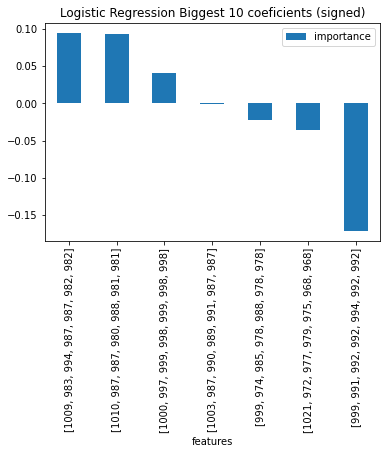

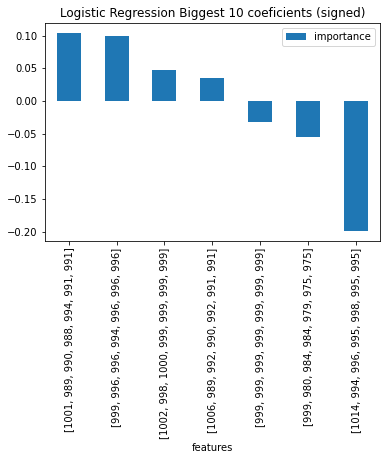

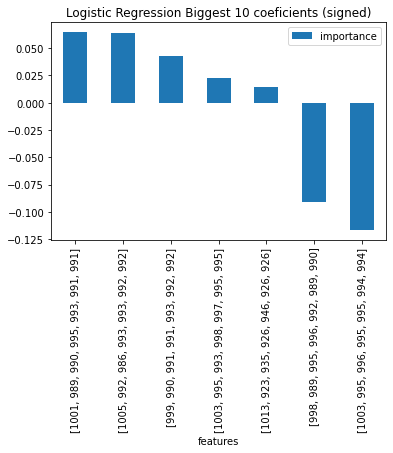

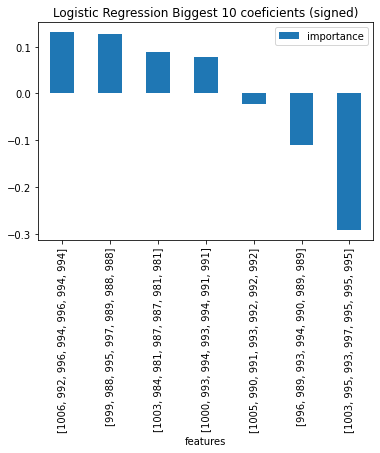

In [294]:
print(clf_log_b_lex.coef_)
print(clf_log_d_lex.coef_)
print(clf_log_e_lex.coef_)
print(clf_log_k_lex.coef_)

def sacar_feature_importance_lr(lr_entrenado, X_test, con_emoticones = True):
    features = X_test
    if not con_emoticones:
        features = [col for col in X_test.columns if ':' not in col]
    coefs = [coef for coef in lr_entrenado.coef_[0]]
    importance = pd\
        .DataFrame(list(zip(features, coefs)), 
                   columns = ['features', 'importance'])\
        .sort_values(by = 'importance', ascending = False)
    importance[:10].plot.bar(x = 'features',y='importance', title = 'Logistic Regression Biggest 10 coeficients (signed)')
    plt.show()

sacar_feature_importance_lr(clf_log_b_lex, test_features_b)
sacar_feature_importance_lr(clf_log_d_lex, test_features_d)
sacar_feature_importance_lr(clf_log_e_lex, test_features_e)
sacar_feature_importance_lr(clf_log_k_lex, test_features_k)


# II. Single Multiclass Classifier

## Training

In [295]:
readers = [books_paths,dvd_paths, electronics_paths, kitchen_paths]
def training_set_read_all():
    documentos = []
    for path in readers:
        for filename in os.listdir(path):
            if filename == 'positive.review' or filename == 'negative.review':
                file_path = os.path.join(path, filename)
                xmldoc = minidom.parse(file_path)
                reviews = xmldoc.getElementsByTagName('review')
                for review in reviews:
                    text = review.getElementsByTagName('review_text')[0].firstChild.nodeValue.strip()
                    if filename == 'positive.review':
                        documentos.append((1,text))
                    elif filename == 'negative.review':
                        documentos.append((0, text))
    return documentos

def testing_set_read_all():
    documentos = []
    for path in readers:
        for filename in os.listdir(path):
            if filename == 'test.review':
                try:
                    file_path = os.path.join(path, filename)
                    xmldoc = minidom.parse(file_path)
                    reviews = xmldoc.getElementsByTagName('review')
                    for review in reviews:
                        text = review.getElementsByTagName('review_text')[0].firstChild.nodeValue.strip()
                        rating = review.getElementsByTagName('rating')[0].firstChild.nodeValue.strip()
                        documentos.append((1 if float(rating) >= 3.5 else 0, text))
                except Exception as e:
                    print(str(e))
                
    return documentos


In [296]:
training_set = training_set_read_all()

df_train = pd.DataFrame(training_set, columns =['label', 'text'])

#Cambiamos las etiquetas texutales por etiquetas numericas, esto es una buena practica cuando se construyen modelo supervisados
print(df_train.shape)
df_train.head() # returns (rows, columns)

(8000, 2)


,label,text
0,0,"This book has its good points. If anything, it..."
1,0,The fatalistic view of Conservativism is expre...
2,0,"I was intrigued by the title, which supposedly..."
3,0,"I admit, I haven't finished this book. A frie..."
4,0,I tried reading this book but found it so turg...


## Testing

In [297]:
testing_set = testing_set_read_all()

print(len(testing_set))

df_test = pd.DataFrame(testing_set, columns =['label', 'text'])

#Cambiamos las etiquetas texutales por etiquetas numericas, esto es una buena practica cuando se construyen modelo supervisados
print(df_test.shape)
df_test.head() # returns (rows, columns)

3329
(3329, 2)


,label,text
0,1,This all-Spanish handbook for parents with new...
1,1,McCarthy's writing and portrayal of Lester Bal...
2,0,Do you giggle uncontrollably when poking corps...
3,1,I was initiated into the world of Cormac McCar...
4,1,I cannot speak to the literary points in the n...


## Building BOW

In [298]:
count_vector = CountVectorizer(tokenizer=tokenizer)
count_vector.fit(df_train['text'])

y_train = df_train['label']

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform((df_train['text']))


C:\Users\allan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [299]:
y_test = df_test['label']

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(df_test['text'])

## Naive Bayes - BOW

In [300]:
naive_bayes = MultinomialNB()

naive_bayes.fit(training_data, y_train)

predictions = naive_bayes.predict(testing_data)

print(confusion_matrix(y_test, predictions))
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))


[[ 492   75]
 [ 707 2055]]
Accuracy score:  0.7650946230099129
Precision score:  0.9647887323943662
Recall score:  0.7440260680666184
F1 score:  0.840147179067866


## Logistic Regression - BOW

In [301]:
clf_log = LogisticRegression(random_state=0).fit(training_data, y_train)

predictions_log = clf_log.predict(testing_data)

print('Accuracy score: ', format(accuracy_score(y_test, predictions_log)))
print('Precision score: ', format(precision_score(y_test, predictions_log)))
print('Recall score: ', format(recall_score(y_test, predictions_log)))
print('F1 score: ', format(f1_score(y_test, predictions_log)))

Accuracy score:  0.8188645238810454
Precision score:  0.9595572584078331
Recall score:  0.8160753077480087
F1 score:  0.8820191743298768


C:\Users\allan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Binary BOW

In [302]:
bin_count_vector = CountVectorizer(tokenizer=tokenizer, binary=True)

bin_count_vector.fit(df_train['text'])

bin_training_data = bin_count_vector.fit_transform((df_train['text']))

# count_vector.get_feature_names() #Retorna el vocabulario del corpus

C:\Users\allan\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


## Naive Bayes - Binary BOW

In [303]:
naive_bayes = MultinomialNB()

naive_bayes.fit(bin_training_data, y_train)

predictions = naive_bayes.predict(testing_data)

print(confusion_matrix(y_test, predictions))

print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

[[ 500   67]
 [ 656 2106]]
Accuracy score:  0.7828176629618504
Precision score:  0.9691670501610676
Recall score:  0.7624909485879797
F1 score:  0.8534954407294832


## Logistic Regression - Binary BOW

In [304]:
clf_log = LogisticRegression(random_state=0).fit(bin_training_data, y_train)

predictions_log = clf_log.predict(testing_data)

print('Accuracy score: ', format(accuracy_score(y_test, predictions_log)))
print('Precision score: ', format(precision_score(y_test, predictions_log)))
print('Recall score: ', format(recall_score(y_test, predictions_log)))
print('F1 score: ', format(f1_score(y_test, predictions_log)))

Accuracy score:  0.7948332832682488
Precision score:  0.9605671245015507
Recall score:  0.7849384503982622
F1 score:  0.86391711496314


## Lexicons

In [305]:
training_features = extract_features_from_dataset(df_train['text'])
testing_features = extract_features_from_dataset(df_test['text'])

print(training_features)
print(testing_features)


[[1027  982  988 ...  991  984  984]
 [1005  937  946 ...  955  940  940]
 [1001  992  990 ...  994  991  991]
 ...
 [1004  998  999 ...  998  996  996]
 [1003 1000 1000 ... 1000 1000 1000]
 [1003 1000  998 ...  998  997  997]]
[[1000  997  999 ...  999  998  998]
 [1003  987  990 ...  991  987  987]
 [ 999  974  985 ...  988  978  978]
 ...
 [1000  997  998 ...  999  997  997]
 [1000  998  998 ... 1000  999  999]
 [1009  992  985 ...  992  991  991]]


## Naive Bayes - Lexicon

In [306]:
naive_bayes_lex = MultinomialNB()

naive_bayes_lex.fit(training_features, y_train)

predictions = naive_bayes_lex.predict(testing_features)

print(confusion_matrix(y_test, predictions))

print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

[[ 428  139]
 [1599 1163]]
Accuracy score:  0.4779212976869931
Precision score:  0.8932411674347158
Recall score:  0.4210716871832006
F1 score:  0.5723425196850395


## Logistic Regresion - Lexicon

In [307]:
clf_log_lr = LogisticRegression(random_state=0).fit(training_features, y_train)

predictions_log = clf_log_lr.predict(testing_features)

print('Accuracy score: ', format(accuracy_score(y_test, predictions_log)))
print('Precision score: ', format(precision_score(y_test, predictions_log)))
print('Recall score: ', format(recall_score(y_test, predictions_log)))
print('F1 score: ', format(f1_score(y_test, predictions_log)))

Accuracy score:  0.5809552418143586
Precision score:  0.8881317433276548
Recall score:  0.5662563359884142
F1 score:  0.6915763873535263


[[ 0.04800031  0.02305327 -0.02171273 -0.0613852  -0.18005902  0.0957175
   0.09622732]]


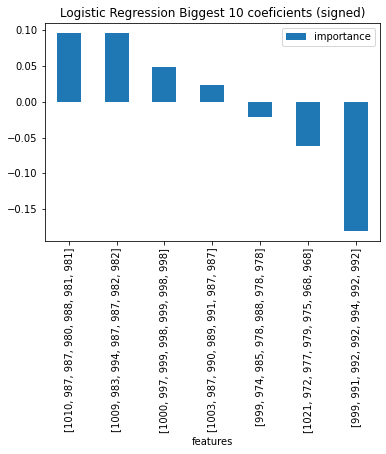

In [308]:
print(clf_log_lr.coef_)

def sacar_feature_importance_lr(lr_entrenado, X_test, con_emoticones = True):
    features = X_test
    if not con_emoticones:
        features = [col for col in X_test.columns if ':' not in col]
    coefs = [coef for coef in lr_entrenado.coef_[0]]
    importance = pd\
        .DataFrame(list(zip(features, coefs)), 
                   columns = ['features', 'importance'])\
        .sort_values(by = 'importance', ascending = False)
    importance[:10].plot.bar(x = 'features',y='importance', title = 'Logistic Regression Biggest 10 coeficients (signed)')
    plt.show()

sacar_feature_importance_lr(clf_log_lr, testing_features)


# IV. Repeat point II using decision trees and random forest. Remember to probe different hyperparameters for random forest model. 

## Decision Tree Clasifier

In [309]:
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(training_data, y_train)
predictions_log_dt = clf_dt.predict(testing_data)

print('Accuracy score: ', format(accuracy_score(y_test, predictions_log_dt)))
print('Precision score: ', format(precision_score(y_test, predictions_log_dt)))
print('Recall score: ', format(recall_score(y_test, predictions_log_dt)))
print('F1 score: ', format(f1_score(y_test, predictions_log_dt)))

Accuracy score:  0.6851907479723641
Precision score:  0.9230009871668312
Recall score:  0.6770456191165822
F1 score:  0.7811194653299917


## Random Forest Classifier

In [311]:
clf_rf = RandomForestClassifier(max_depth=10, random_state=0)
clf_rf_2 = RandomForestClassifier(max_depth=10, random_state=0, min_samples_split=3)
clf_rf_3 = RandomForestClassifier(max_depth=5, random_state=0)
clf_rf_4 = RandomForestClassifier(max_depth=10, random_state=0, min_samples_leaf=3)
clf_rf_5 = RandomForestClassifier(max_depth=15, random_state=0)

## Los métodos ensamblados de arboles tienden a hacer overfitting, un must do es hacer validación cruzada
clf_rf.fit(training_data, y_train)
clf_rf_2.fit(training_data, y_train)
clf_rf_3.fit(training_data, y_train)
clf_rf_4.fit(training_data, y_train)
clf_rf_5.fit(training_data, y_train)


predictions_log_rf = clf_rf.predict(testing_data)
predictions_log_rf_2 = clf_rf_2.predict(testing_data)
predictions_log_rf_3 = clf_rf_3.predict(testing_data)
predictions_log_rf_4 = clf_rf_4.predict(testing_data)
predictions_log_rf_5 = clf_rf_5.predict(testing_data)


print('Accuracy score: ', format(accuracy_score(y_test, predictions_log_rf)))
print('Precision score: ', format(precision_score(y_test, predictions_log_rf)))
print('Recall score: ', format(recall_score(y_test, predictions_log_rf)))
print('F1 score: ', format(f1_score(y_test, predictions_log_rf)))
print("-----------------------------------------")
print('Accuracy score: ', format(accuracy_score(y_test, predictions_log_rf_2)))
print('Precision score: ', format(precision_score(y_test, predictions_log_rf_2)))
print('Recall score: ', format(recall_score(y_test, predictions_log_rf_2)))
print('F1 score: ', format(f1_score(y_test, predictions_log_rf_2)))
print("-----------------------------------------")
print('Accuracy score: ', format(accuracy_score(y_test, predictions_log_rf_3)))
print('Precision score: ', format(precision_score(y_test, predictions_log_rf_3)))
print('Recall score: ', format(recall_score(y_test, predictions_log_rf_3)))
print('F1 score: ', format(f1_score(y_test, predictions_log_rf_3)))
print("-----------------------------------------")
print('Accuracy score: ', format(accuracy_score(y_test, predictions_log_rf_3)))
print('Precision score: ', format(precision_score(y_test, predictions_log_rf_3)))
print('Recall score: ', format(recall_score(y_test, predictions_log_rf_3)))
print('F1 score: ', format(f1_score(y_test, predictions_log_rf_3)))
print("-----------------------------------------")
print('Accuracy score: ', format(accuracy_score(y_test, predictions_log_rf_5)))
print('Precision score: ', format(precision_score(y_test, predictions_log_rf_5)))
print('Recall score: ', format(recall_score(y_test, predictions_log_rf_5)))
print('F1 score: ', format(f1_score(y_test, predictions_log_rf_5)))


Accuracy score:  0.7689996996094923
Precision score:  0.9399558498896248
Recall score:  0.7708182476466329
F1 score:  0.8470260592798886
-----------------------------------------
Accuracy score:  0.7738059477320517
Precision score:  0.9423161602818142
Recall score:  0.774800868935554
F1 score:  0.8503874428770117
-----------------------------------------
Accuracy score:  0.7584860318413938
Precision score:  0.9286339754816112
Recall score:  0.7679217958001449
F1 score:  0.8406658739595719
-----------------------------------------
Accuracy score:  0.7584860318413938
Precision score:  0.9286339754816112
Recall score:  0.7679217958001449
F1 score:  0.8406658739595719
-----------------------------------------
Accuracy score:  0.7834184439771703
Precision score:  0.9466083150984683
Recall score:  0.7831281679942071
F1 score:  0.8571428571428571
